# Brain Tumor Classification TrainBaseModelAugmentation
----
What was done in this notebook: 
- Applied small image augmentations to the training dataset (rotation, vertical & horizontal shift,  zoom, horizontal flip, rescaling)
- Trained two transfer learning models:
  - VGG19 (no meaningful improvement from augmentation)
  - ResNet50 (significant improvement in validation accuracy and loss)
  
Some challenges/What went wrong:
- VGG19 was super slow and didn’t learn well ,  accuracy got stuck around 28–30%.
- My laptop couldn’t handle training and crashed, so I had to switch to my PC
- TensorFlow gave some weird warning about workers and use_multiprocessing, but I ignored it since training still worked

What went well:
- ResNet50 with image augmentation worked great — hit 94% validation accuracy (but low val accuracy at first few epochs but got better, could be due to some overfitting)
- Only saved the ResNet50 model since VGG19 didn’t perform well

----

In [8]:
# import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle


# keras & tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19, ResNet50

In [3]:
# for loading previous code and reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

data_dir = 'tumor_data'
train_dir = os.path.join(data_dir, 'Training')
test_dir = os.path.join(data_dir, 'Testing')

In [4]:
# generate data
img_size = 224
batch_size = 32 # this is using my PC

train_datagen_aug = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10, # rotate the image just 10 deg, not too much for mri 
    width_shift_range=0.1, # just a bit of shifting 
    height_shift_range=0.1,
    zoom_range=0.2, # zoom into the image 
    horizontal_flip=True,
    fill_mode='nearest'
)

#for validation data without augmentation
val_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

# augmented training data
train_gen_aug = train_datagen_aug.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size= batch_size,
    shuffle=True
)

# validation data
val_gen = val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


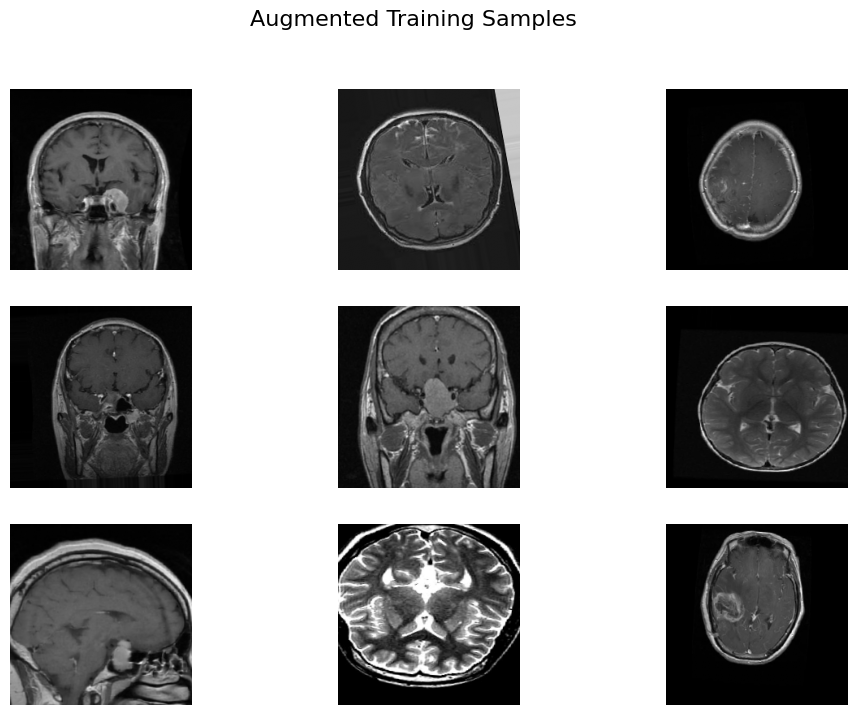

In [5]:
# now to look at augmented data
augmented_images, labels = next(train_gen_aug)

plt.figure(figsize=(12,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(augmented_images[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Augmented Training Samples", fontsize=16)
plt.show()

In [6]:
# transfer learning model
def make_transfer_model(base_name='VGG19', input_shape=(224, 224, 1), n_classes=4):

    # load in previous base model w/o top classification head
    if base_name == 'VGG19':
        base = VGG19(
            weights='imagenet',        
            include_top=False,       
            input_shape=(224, 224, 3)  
        )
    elif base_name == 'ResNet50':
        base = ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3)
        )
    else:
        raise ValueError("Invalid model name: choose 'VGG19' or 'ResNet50'")

    # custom input layer for grayscale data
    inputs = keras.Input(shape=input_shape)  

    # convert to grayscale (1 to 3 channels) by concatenation
    x = layers.Concatenate()([inputs, inputs, inputs])  
    x = base(x, training=False) 
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x) # dropout for regularization, helps prevent overfitting

    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

---
### **Train VGG19 with augmentation**

In [7]:
#### VGG19 with augmentation
print("Training VGG19 with augmentation")
vgg_aug_model = make_transfer_model('VGG19')
vgg_aug_history = vgg_aug_model.fit(
    train_gen_aug,
    validation_data=val_gen,
    epochs=10,
    verbose=1
)

Training VGG19 with augmentation
Epoch 1/10


C:\Users\eliga\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 1574s 9s/step - accuracy: 0.2503 - loss: 1.4324 - val_accuracy: 0.3089 - val_loss: 1.3830
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1565s 9s/step - accuracy: 0.2808 - loss: 1.3837 - val_accuracy: 0.3089 - val_loss: 1.3818
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1585s 9s/step - accuracy: 0.2800 - loss: 1.3834 - val_accuracy: 0.3089 - val_loss: 1.3810
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1649s 9s/step - accuracy: 0.2777 - loss: 1.3836 - val_accuracy: 0.3089 - val_loss: 1.3807
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1554s 9s/step - accuracy: 0.2834 - loss: 1.3826 - val_accuracy: 0.3089 - val_loss: 1.3805
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1548s 9s/step - accuracy: 0.2768 - loss: 1.3840 - val_accuracy: 0.3089 - val_loss: 1.3806
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1544s 9s/step - accuracy: 0.2774 - loss: 1.3830 - val_accuracy: 0.3089 - val_loss: 1.3805
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1543s 9s/step - accuracy: 0.2868 - loss: 1.3815 - val_accurac

### **ResNet50 with augmentation**

In [7]:
resnet_model = make_transfer_model('ResNet50')
resnet_history = resnet_model.fit(
    train_gen_aug,
    validation_data=val_gen,
    epochs=10,
    verbose=1
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


C:\Users\eliga\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 802s 4s/step - accuracy: 0.8005 - loss: 0.5645 - val_accuracy: 0.3089 - val_loss: 1.7346
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 773s 4s/step - accuracy: 0.9090 - loss: 0.2681 - val_accuracy: 0.3059 - val_loss: 2.5961
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 768s 4s/step - accuracy: 0.9446 - loss: 0.1891 - val_accuracy: 0.2304 - val_loss: 9.0727
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 768s 4s/step - accuracy: 0.9474 - loss: 0.1578 - val_accuracy: 0.2715 - val_loss: 9.1595
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 756s 4s/step - accuracy: 0.9529 - loss: 0.1333 - val_accuracy: 0.4676 - val_loss: 2.6903
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 756s 4s/step - accuracy: 0.9569 - loss: 0.1184 - val_accuracy: 0.5629 - val_loss: 2.6149
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 756s 4s/step - accuracy: 0.9663 - loss: 0.1051 - val_accuracy: 0.8215 - val_loss: 0.6082
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 757s 4s/step - accuracy: 0.9718 - loss: 0.0890 - val_accu

In [11]:
# save ResNet50 model
resnet_model.save('resnet50_augmented_model.h5')

In [14]:
# save the training history for ROC curves for comparisons later
with open('resnet50_augmented_history.pkl', 'wb') as f:
    pickle.dump(resnet_history.history, f)